In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML, IFrame
from ipywidgets import interact,fixed, FloatSlider, IntSlider, Dropdown, HBox, VBox, Checkbox
# import pandas as pd
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import axes3d

from numpy.linalg import norm
from numpy import cos,sin,tan,arctan,exp,log,pi,sqrt,array,arange,linspace,meshgrid

from ipykernel.pylab.backend_inline import flush_figures

from scipy.integrate import quad, dblquad, tplquad

%matplotlib widget

plt.rcParams.update({
    "figure.figsize": (7, 7),
    "text.usetex": True,
    "font.family": "serif",
})

# Uncomment the one that corresponds to your Jupyter theme
plt.style.use('default')
# plt.style.use('dark_background')
# plt.style.use('fivethirtyeight')
# plt.style.use('Solarize_Light2')

In [2]:
%%html

<style>
.shadow {

    /*Edit or add new attributes, change size, color, etc */
    width: 75%;
    box-shadow: 8px 8px 10px #444;
    border: 1px solid silver;

    /*For positioning in a jupyter notebook*/
    margin-top: 2em;
    position: relative;
    top: -25px
}

ol li {
    padding: .5em;
}

th, td {
    font-size: large;
}
</style>

$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\bv}[1]{\begin{bmatrix} #1 \end{bmatrix}}$
$\renewcommand{\vec}{\mathbf}$

<style>
    td {
      font-size: 1.5em;
    }
</style>

# One-minute Review

### Example

Consider the vector field $\vec F(x,y,z) = x\,\vec i$. Consider the surfaces

  - $\Omega_1$: piece of the plane $x=0$ for $0 \leq y,z \leq 1$
  - $\Omega_2$: piece of the surface $x= 3y(1-y)$ for $0 \leq y,z \leq 1$

oriented in the positive $x$-direction. Through which surface is the flux of $\vec F$ greater?

In [3]:
def a(TITLE):
    if TITLE in plt.get_figlabels():
        plt.close(plt.figure(TITLE))
    
    plt.ioff()
    fig = plt.figure(num=TITLE)
    plt.ion()
    ax = fig.add_subplot(projection='3d') 
    
    # make axes lines
    ax.plot([0,1],[0,0],[0,0],'gray')
    ax.plot([0,0],[0,1],[0,0],'gray')
    ax.plot([0,0],[0,0],[0,1],'gray')   

    for c in 'xyz':
        getattr(ax,f"set_{c}lim")([0,1]);    
        getattr(ax,f"set_{c}label")(f"${c}$",size=16)
    
    ax.set_autoscale_on(True)

    slider = Checkbox(description="caps")
    caps = slider.value

    
    u = np.linspace(0,1,20)
    v = np.linspace(0,1,10)
    U,V = np.meshgrid(u,v)
    ax.plot_surface(0*U*(1-U),U,V,alpha=.5)
    ax.plot_wireframe(0*U*(1-U),U,V,alpha=1,color='k',rcount=10,ccount=10)
    ax.plot_surface(3*U*(1-U),U,V,alpha=.5)
    ax.plot_wireframe(3*U*(1-U),U,V,alpha=1,color='k',rcount=10,ccount=10)
    cstuff = [
        ax.plot_surface(3*V*U*(1-U),U,np.ones_like(V),alpha=0),
        ax.plot_wireframe(3*V*U*(1-U),U,np.ones_like(V),alpha=0,color='k',rcount=10,ccount=10),
        ax.plot_surface(3*V*U*(1-U),U,np.zeros_like(V),alpha=0),
        ax.plot_wireframe(3*V*U*(1-U),U,np.zeros_like(V),alpha=0,color='k',rcount=10,ccount=10)
    ]

    u = v = np.linspace(0,1,7)
    # v = np.linspace(0,2*pi,10)
    U,V,W = np.meshgrid(u,v,u)
    ax.quiver(U,V,W,U,0*U,0*U,length=.2);
    
    def update(change):
        caps = slider.value
        for c in cstuff:
            c.set_alpha(caps and .7 or 0)
    
    slider.observe(update, names='value')
    
    return VBox([slider, fig.canvas])

a("2 Fluxes")

<p style="padding-bottom:40%;"> </p>

# Lecture 23
## The Divergence Theorem

  - Objectives
    - Div and Curl
      - "del" operator $\nabla$
    - Divergence Theorem
      - know what divergence measures
      - describe it as a conservation law
      - use it to compute flux

  - Resources
    - Content
      - Stewart: §16.6-9
      - New Strang:  
        - [§6.5](https://openstax.org/books/calculus-volume-3/pages/6-5-divergence-and-curl) [§6.6](https://openstax.org/books/calculus-volume-3/pages/6-6-surface-integrals) [§6.8](https://openstax.org/books/calculus-volume-3/pages/6-8-the-divergence-theorem)
      - [3Demos](https://drew.youngren.nyc/3Demos/surfint/)
      - Mooculus: [Surface Integrals](https://ximera.osu.edu/mooculus/calculus3/shapeOfThingsToCome/digInSurfaceIntegrals) [Divergence Theorem](https://ximera.osu.edu/mooculus/calculus3/shapeOfThingsToCome/digInDivergenceTheorem)
    - Extras 
      - CalcBLUE: [2-Form Fields](https://www.youtube.com/watch?v=LNaAEy_K-Cg&list=PL8erL0pXF3JYCn8Xukv0DqVIXtXJbOqdo&index=64) *Use with caution. This is a different and more general formulation of surface integrals. 

<p style="padding-bottom:40%;"> </p>

## Div, curl, etc.

Recall out notation $$\nabla = \frac{\partial}{\partial x} \,\vec i + \frac{\partial}{\partial y} \,\vec j + \frac{\partial}{\partial z} \,\vec k $$

Applying vector operations to this "vector" yields different kinds of derivatives:

<style>
    td {
        font-size: 1.5;
        color: red;
    }
</style>

<table style="font-size: 1em;">
    <tr>
        <th>name</th>
        <th>form</th>
        <th>in</th>
        <th>out</th>
    </tr>
    <tr>
        <td>derivative</td>
        <td> $$\frac{d}{dx} f(x)$$ </td>
        <td>scalar</td>
        <td>scalar</td>
    </tr>
    <tr><td>partial </td><td> $$\frac{\partial}{\partial x}f(x,y)$$ </td><td> scalar </td><td> scalar </td></tr> 
    <tr><td>grad </td><td> $$\nabla f(x,y)$$ </td><td> scalar </td><td> vector </td></tr> 
    <tr><td>div </td><td> $$\nabla \cdot \vec F(x,y,z)$$ </td><td> vector </td><td> scalar </td></tr> 
    <tr><td>curl </td><td> $$\nabla \times \vec F(x,y,z)$$ </td><td> vector </td><td> vector </td></tr> 
</table>

<!-- | name |&nbsp; form| in | out |
|---|---|---|---|
|derivative | &nbsp; $$\frac{d}{dx} f(x)$$ | scalar | scalar | 
|partial | $\frac{\partial}{\partial x}f(x,y)$ | scalar | scalar | 
| grad | $\nabla f(x,y)$ | scalar | vector |
| div | $\nabla \cdot \vec F(x,y,z)$ | vector | scalar |
| curl | $\nabla \times \vec F(x,y,z)$ | vector | vector | -->

<p style="padding-bottom:40%;"> </p>

# Another Big Theorem

Recall the special form of Green's Theorem in 2D.

$$ \oint_{\partial D} \vec F \cdot d \vec n = \iint_D (P_x + Q_y)\,dA$$ for a smooth vector field $\vec F = P \,\vec i + Q\,\vec j$. Note, the integrand on the right is (2D) divergence $\nabla \cdot \vec F $. 

<p style="padding-bottom:40%;"> </p>

## The Divergence Theorem

Let $E$ be a solid region in $\RR^3$ and $\partial E$ its outward-oriented boundary. If $\vec F(x,y,z)$ is a smooth vector field, then

$$ \iint_{\partial E} \vec F \cdot \vec N\,d S = \iiint_E \nabla \cdot \vec F\,dV$$

In [4]:
def a(TITLE):
    if TITLE in plt.get_figlabels():
        plt.close(plt.figure(TITLE))
    
    plt.ioff()
    fig = plt.figure(num=TITLE)
    plt.ion()
    ax = fig.add_subplot(projection='3d') 
    
    u = np.linspace(0,pi,150)
    v = np.linspace(0,2*pi,100)
    U,V = np.meshgrid(u,v)
    rd = 1+1/3*sin(U*2)**2*sin(V*3)**2
    srf = rd*sin(U)*cos(V),rd*sin(U)*sin(V),rd*cos(U)
    
    zoom = 1
    poly_stuff = []
    q_stuff = []
    
    
    p = ax.plot_surface(*srf,alpha=.5*zoom,color='g')
    q_stuff.append(ax.plot_wireframe(*srf, alpha=zoom, color='k', rcount=10, ccount=10))
    u = v = np.linspace(-1,1,7)
    # v = np.linspace(0,2*pi,10)
    U,V,W = np.meshgrid(u,v,u)
    q_stuff.append(ax.quiver(U,(V),W,U,V,W, length=.2, alpha=zoom))
    U,V = meshgrid([0,1],[0,1])
    srf = .05*U,0,.05*V
    
    poly_stuff.append(ax.plot_surface(*srf,alpha=.7*(1-zoom),color='b'))
    poly_stuff.append(ax.plot_wireframe(*srf,alpha=.7*(1-zoom),color='k',rcount=10,ccount=10))
    srf = .05,.05*U,.05*V
    poly_stuff.append(ax.plot_surface(*srf,alpha=.7*(1-zoom),color='b'))
    poly_stuff.append(ax.plot_wireframe(*srf,alpha=.7*(1-zoom),color='k',rcount=10,ccount=10))
    srf = .05*U,.05*V,.05 + U*0
    poly_stuff.append(ax.plot_surface(*srf,alpha=.7*(1-zoom),color='b'))
    poly_stuff.append(ax.plot_wireframe(*srf,alpha=.7*(1-zoom),color='k',rcount=10,ccount=10))
    srf = .05*U,.05,.05*V
    poly_stuff.append(ax.plot_surface(*srf,alpha=.7*(1-zoom),color='b'))
    poly_stuff.append(ax.plot_wireframe(*srf,alpha=.7*(1-zoom),color='k',rcount=10,ccount=10))

    U,V,W = np.meshgrid([0.,1.,2.],[0.,1.,2.],[0.,1.,2.])

    q = ax.quiver(.025*U,(.025*V),.025*W,.025*U,.025*V,.025*W,length=.2,alpha=(1 - zoom));

    for c in 'xyz':
        getattr(ax,f"set_{c}lim")([-zoom,.1+.9*zoom])

    
    slider = FloatSlider(min=0, max=1, step=.02, value=1)
    
    def update(change):
        zoom = slider.value
        
        for c in 'xyz':
            getattr(ax,f"set_{c}lim")([-zoom,.1+.9*zoom])
            
        p.set_alpha(.5*zoom)
        q.set_alpha(1 - zoom)
        for x in poly_stuff:
            x.set_alpha(.7*(1-zoom))
        for x in q_stuff:
            x.set_alpha(zoom)
    
    slider.observe(update, names='value')
    
    return VBox([slider, fig.canvas])

a("Divergence Theorem")

#### Justification

$$\iint_{\partial E} \vec F\cdot \vec N\,dS \approx \sum\Delta \text{flux} $$

$$ \Delta\text{flux}_{x\text{-dir}} = \left(P\left(x + \frac{\Delta x}{2}, y, z\right) - P\left(x - \frac{\Delta x}{2}, y, z\right)\right) \Delta y\,\Delta z$$

$$\approx P_x(x,y,z)\, \Delta x\,\Delta y\,\Delta z$$

Similarly, 

$$ \Delta\text{flux}_{y\text{-dir}} \approx Q_y(x,y,z)\, \Delta x\,\Delta y\,\Delta z$$

$$ \Delta\text{flux}_{z\text{-dir}} \approx R_z(x,y,z)\, \Delta x\,\Delta y\,\Delta z$$

Add these together, to get

$$\sum\Delta \text{flux} = \sum (P_x + Q_y + R_z) \, \Delta x\,\Delta y\,\Delta z$$

$$ \longrightarrow \iiint_E \operatorname{div} \vec F dV $$

###
<p style="padding-bottom:40%;"> </p>

#### How to remember DT

  - Maxwell's equation
     $$\nabla\cdot \vec E = \rho$$
Charge density is the divergence of the electric field. 


![Screengrab for Electric Field Hockey](../img/efh.png)

Courtesy: [Electric Field Hockey](https://phet.colorado.edu/en/simulation/electric-hockey)

<p style="padding-bottom:40%;"> </p>

  - Champagne
  
![Mets' Terry CVollins spraying champagne in 2015](https://1.bp.blogspot.com/-UEzDm6Zzhco/ViioEBfuJVI/AAAAAAAAfak/Wv_PQY8hs-w/s1600/-fa3579127e7e3ceb.JPG)

Terry Collins knows the Divergence Theorem. Photo credit: [John Munson | NJ Advance Media for NJ.com](https://www.nj.com/mets/2015/10/look_inside_mets_clubhouse_as_they_celebrate_world.html)

<p style="padding-bottom:40%;"> </p>

#### 

<p style="padding-bottom:40%;"> </p>

### Example - Radial field

Compute the flux of the radial vector field $x\,\vec i + y\,\vec j + z\,\vec k$ through the outward-oriented unit sphere. 
  
[3Demos demo](https://drew.youngren.nyc/3Demos/surfint/index.html?a=0.0001&b=pi&c=0&d=2+pi&x=sin%28u%29+cos%28v%29&y=sin%28u%29+sin%28v%29&z=cos%28u%29&P=x&Q=y&R=z&E=z%5E2+-+%28x%5E2+%2B+y%5E2%29%2F.999&colorFunc=false&surfaceVisible=true&frameBallVisible=false&trailsVisible=true&S=spheres&nX=80&rNum=10&cNum=10&shards=0&nVec=5)

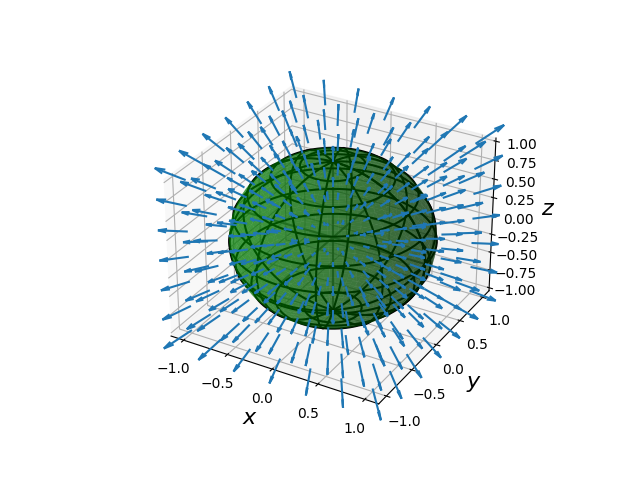

In [5]:
def a(TITLE):
    if TITLE in plt.get_figlabels():
        plt.close(plt.figure(TITLE))
    
    plt.ioff()
    fig = plt.figure(num=TITLE)
    plt.ion()
    ax = fig.add_subplot(projection='3d') 
    
    # make axes lines
    ax.plot([-1,1],[0,0],[0,0],'gray')
    ax.plot([0,0],[-1,1],[0,0],'gray')
    ax.plot([0,0],[0,0],[-1,1],'gray')   

    for c in 'xyz':
        getattr(ax,f"set_{c}lim")([-1,1]);    
        getattr(ax,f"set_{c}label")(f"${c}$",size=16)
    
    ax.set_autoscale_on(True)
    
    u = np.linspace(0,pi,100)
    v = np.linspace(0,2*pi,100)
    U,V = np.meshgrid(u,v)
    ax.plot_surface(sin(U)*cos(V),sin(U)*sin(V),cos(U),alpha=.5,color='g')
    ax.plot_wireframe(sin(U)*cos(V),sin(U)*sin(V),cos(U),alpha=1,color='k',rcount=10,ccount=10)
    u = v = np.linspace(-1,1,7)
    # v = np.linspace(0,2*pi,10)
    U,V,W = np.meshgrid(u,v,u)
    ax.quiver(U,(V),W,U,V,W,length=.2);
    
    return fig.canvas

a("Radial Field")



<p style="padding-bottom:40%;"> </p>

### Example - Revisit Cone

Find the flux of the vector field $(1 - x)\,\vec i - y\, \vec j$ through the piece of the cone $z=\sqrt{x^2 + y^2}$ below $z=2$, oriented upward.

[3Demos demo](https://drew.youngren.nyc/3Demos/surfint/index.html?a=0&b=2&c=0&d=2*pi&x=u+cos%28v%29&y=u+sin%28v%29&z=u&P=1+-+x&Q=-y&R=0&E=x%5E2+%2B+y%5E2&divergence=false&curl=false&colorFunc=false&surfaceVisible=true&tanFrameVisible=false&trailsVisible=true&S=graphs&nX=30&rNum=10&cNum=10&shards=0&nVec=6&scale=0.42)

In [6]:
def a(TITLE):
    if TITLE in plt.get_figlabels():
        plt.close(plt.figure(TITLE))
    
    plt.ioff()
    fig = plt.figure(num=TITLE, figsize=(6,6))
    plt.ion()
    ax = fig.add_subplot(projection='3d') 
    
    capper = Checkbox(description="top")
    
    # make axes lines
    ax.plot([-1,1],[0,0],[0,0],'gray')
    ax.plot([0,0],[-1,1],[0,0],'gray')
    ax.plot([0,0],[0,0],[-1,1],'gray')   

    for c in 'xyz':
        getattr(ax,f"set_{c}lim")([-1,1]);    
        getattr(ax,f"set_{c}label")(f"${c}$",size=16)
    
    ax.set_autoscale_on(True)
    
    u = np.linspace(0,2,100)
    v = np.linspace(0,2*pi,100)
    U,V = np.meshgrid(u,v)
    ax.plot_surface(U*cos(V),U*sin(V),U,alpha=.5,color='g')
    ax.plot_wireframe(U*cos(V),U*sin(V),U,alpha=1,color='k',rcount=10,ccount=10)
    cstuff = [ax.plot_surface(U*cos(V),U*sin(V),2*np.ones_like(U),alpha=0),            
              ax.plot_wireframe(U*cos(V),U*sin(V),2*np.ones_like(U),alpha=0,color='k',rcount=10,ccount=10)]
    
    def update(change):
        for c in cstuff:
            c.set_alpha(capper.value and .7 or 0)
            
            
    u = v = np.linspace(-2,2,8)
    # v = np.linspace(0,2*pi,10)
    U,V,W = np.meshgrid(u,v,u)
    ax.quiver(U,V,W,1 - U,-V,0*U,length=.2);
    
    capper.observe(update, names='value')
    return VBox([capper, fig.canvas])

a("Cone 2")



<p style="padding-bottom:40%;"> </p>

### Example Fishing in a river

We revisit an example from [lecture on flux integrals](L21-Exercises-Solutions.ipynb).

Consider the constant vector field $\vec F(x,y,z) = \vec i$. Consider the surfaces

  - $\Omega_1$: piece of the plane $x=0$ for $(0 \leq y,z \leq 1$
  - $\Omega_2$: piece of the surface $x= 3y(1-y)$ for $0 \leq y,z \leq 1$

oriented in the positive $x$-direction. Through which surface is the flux of $\vec F$ greater?

In [7]:
def a(TITLE):
    if TITLE in plt.get_figlabels():
        plt.close(plt.figure(TITLE))
    
    plt.ioff()
    fig = plt.figure(num=TITLE)
    plt.ion()
    ax = fig.add_subplot(projection='3d') 
    
    # make axes lines
    ax.plot([0,1],[0,0],[0,0],'gray')
    ax.plot([0,0],[0,1],[0,0],'gray')
    ax.plot([0,0],[0,0],[0,1],'gray')   

    for c in 'xyz':
        getattr(ax,f"set_{c}lim")([0,1]);    
        getattr(ax,f"set_{c}label")(f"${c}$",size=16)
    
    ax.set_autoscale_on(True)

    slider = Checkbox(description="caps")
    caps = slider.value

    
    u = np.linspace(0,1,20)
    v = np.linspace(0,1,10)
    U,V = np.meshgrid(u,v)
    ax.plot_surface(0*U*(1-U),U,V,alpha=.5)
    ax.plot_wireframe(0*U*(1-U),U,V,alpha=1,color='k',rcount=10,ccount=10)
    ax.plot_surface(3*U*(1-U),U,V,alpha=.5)
    ax.plot_wireframe(3*U*(1-U),U,V,alpha=1,color='k',rcount=10,ccount=10)
    cstuff = [
        ax.plot_surface(3*V*U*(1-U),U,np.ones_like(V),alpha=0),
        ax.plot_wireframe(3*V*U*(1-U),U,np.ones_like(V),alpha=0,color='k',rcount=10,ccount=10),
        ax.plot_surface(3*V*U*(1-U),U,np.zeros_like(V),alpha=0),
        ax.plot_wireframe(3*V*U*(1-U),U,np.zeros_like(V),alpha=0,color='k',rcount=10,ccount=10)
    ]

    u = v = np.linspace(0,1,7)
    # v = np.linspace(0,2*pi,10)
    U,V,W = np.meshgrid(u,v,u)
    ax.quiver(U,V,W,np.ones_like(U),0*U,0*U,length=.2);
    
    def update(change):
        caps = slider.value
        for c in cstuff:
            c.set_alpha(caps and .7 or 0)
    
    slider.observe(update, names='value')
    
    return VBox([slider, fig.canvas])

a("River 1")

<p style="padding-bottom:40%;"> </p>

#### Solution

Let $\Omega_1$ and $\Omega_2$ be as before (with a negative sign indicating an opposite orientation) and $T_1$ and $T_0$ be the enclosing, upward-oriented "caps" to the solid at $z=1$ and $z=0$, respectively. 

$$ \iint_{\Omega_2} \vec F\cdot d\vec S + \iint_{-\Omega_1} \vec F\cdot d\vec S + \iint_{T_1} \vec F\cdot d\vec S + \iint_{-T_0} \vec F\cdot d\vec S = \iiint_E \nabla\cdot \vec F\,dV $$ 

$$ \iint_{\Omega_2} \vec F\cdot d\vec S - \iint_{\Omega_1} \vec F\cdot d\vec S = 0 $$ 

#### 
<p style="padding-bottom:40%;"> </p>

### Exercise

In the example immediately above, change the vector field to $x\,\vec i$ and use the Divergence Theorem to compute the flux through $\Omega_2$. 

In [8]:
def a(TITLE):
    if TITLE in plt.get_figlabels():
        plt.close(plt.figure(TITLE))
    
    plt.ioff()
    fig = plt.figure(num=TITLE)
    plt.ion()
    ax = fig.add_subplot(projection='3d') 
    
    # make axes lines
    ax.plot([0,1],[0,0],[0,0],'gray')
    ax.plot([0,0],[0,1],[0,0],'gray')
    ax.plot([0,0],[0,0],[0,1],'gray')   

    for c in 'xyz':
        getattr(ax,f"set_{c}lim")([0,1]);    
        getattr(ax,f"set_{c}label")(f"${c}$",size=16)
    
    ax.set_autoscale_on(True)

    slider = Checkbox(description="caps")
    caps = slider.value

    
    u = np.linspace(0,1,20)
    v = np.linspace(0,1,10)
    U,V = np.meshgrid(u,v)
    ax.plot_surface(0*U*(1-U),U,V,alpha=.5)
    ax.plot_wireframe(0*U*(1-U),U,V,alpha=1,color='k',rcount=10,ccount=10)
    ax.plot_surface(3*U*(1-U),U,V,alpha=.5)
    ax.plot_wireframe(3*U*(1-U),U,V,alpha=1,color='k',rcount=10,ccount=10)
    cstuff = [
        ax.plot_surface(3*V*U*(1-U),U,np.ones_like(V),alpha=0),
        ax.plot_wireframe(3*V*U*(1-U),U,np.ones_like(V),alpha=0,color='k',rcount=10,ccount=10),
        ax.plot_surface(3*V*U*(1-U),U,np.zeros_like(V),alpha=0),
        ax.plot_wireframe(3*V*U*(1-U),U,np.zeros_like(V),alpha=0,color='k',rcount=10,ccount=10)
    ]

    u = v = np.linspace(0,1,7)
    # v = np.linspace(0,2*pi,10)
    U,V,W = np.meshgrid(u,v,u)
    ax.quiver(U,V,W,U,0*U,0*U,length=.2);
    
    def update(change):
        caps = slider.value
        for c in cstuff:
            c.set_alpha(caps and .7 or 0)
    
    slider.observe(update, names='value')
    
    return VBox([slider, fig.canvas])

a("River 2")

<p style="padding-bottom:40%;"> </p>

### Example - Buoyancy

Recall that hydrostatic pressure is proportional to depth. $P = \rho g d$. The force on a small piece of submerged surface is $P\, \vec N\,dS$ where $\vec N$ is the normal vector to the surface. The (net) buoyant force on the hull of a watercraft is the component of this force in the upward direction. 

Use the Divergence Theorem to relate the buoyant force to the volume of a submerged object. 

In [9]:
def a(TITLE):
    if TITLE in plt.get_figlabels():
        plt.close(plt.figure(TITLE))
    
    plt.ioff()
    fig = plt.figure(num=TITLE)
    plt.ion()
    ax = fig.add_subplot(projection='3d') 
    
    xyz0 = (0.5833333333333334, 0.5833333333333333, 0.8249579113843055)
    
    zoom = 1
    
    
    # blob
    u = np.linspace(0,pi,300)
    v = np.linspace(0,2*pi,300)
    U,V = np.meshgrid(u,v)
    rd = 1+1/3*sin(U*2)**2*sin(V*3)**2
    srf = rd*sin(U)*cos(V),rd*sin(U)*sin(V),rd*cos(U)
    p1 = ax.plot_surface(*srf,alpha=.4*zoom + .1,color='g')
    ax.plot_wireframe(*srf,alpha=1,color='k',rcount=10,ccount=10)
    
    # normal vectors
    u = np.linspace(0,pi,9)
    v = np.linspace(0,2*pi,17)
    U,V = np.meshgrid(u,v)
    rd = 1+1/3*sin(U*2)**2*sin(V*3)**2
    srf = rd*sin(U)*cos(V),rd*sin(U)*sin(V),rd*cos(U)
    ax.quiver(*srf, 
              -(((sin(2*U)**2*sin(3*V)**2 + 3)*cos(V) + 6*sin(2*U)**2*sin(V)*sin(3*V)*cos(3*V))*(-20*sin(U)**4*sin(3*V)**2 + 28*sin(U)**2*sin(3*V)**2 - 8*sin(3*V)**2 + 3) + 24*(-20*sin(U)**4*sin(3*V)**2 + 12*sin(U)**2*sin(3*V)**2 + 3)*sin(V)*sin(3*V)*cos(U)**4*cos(3*V))*sin(U)**2/9,
              -(((sin(2*U)**2*sin(3*V)**2 + 3)*sin(V) - 6*sin(2*U)**2*sin(3*V)*cos(V)*cos(3*V))*(-20*sin(U)**4*sin(3*V)**2 + 28*sin(U)**2*sin(3*V)**2 - 8*sin(3*V)**2 + 3) - 24*(-20*sin(U)**4*sin(3*V)**2 + 12*sin(U)**2*sin(3*V)**2 + 3)*sin(3*V)*cos(U)**4*cos(V)*cos(3*V))*sin(U)**2/9,
              -(-20*sin(U)**4*sin(3*V)**2 + 12*sin(U)**2*sin(3*V)**2 + 3)*(-4*sin(U)**4*sin(3*V)**2 + 4*sin(U)**2*sin(3*V)**2 + 3)*sin(U)*cos(U)/9,
              length=.2,alpha=1);
    
    # small patch
    u = v = np.linspace(pi/4-.1,pi/4+.1,30)
    U,V = np.meshgrid(u,v)
    rd = 1+1/3*sin(U*2)**2*sin(V*3)**2
    srf = rd*sin(U)*cos(V),rd*sin(U)*sin(V),rd*cos(U)
    p2 = ax.plot_surface(*srf,alpha=.7*(1-zoom),color='b')
    p3 = ax.plot_wireframe(*srf,alpha=.7*(1-zoom),color='k',rcount=4,ccount=4)

    U,V,W = np.meshgrid([0.,1.,2.],[0.,1.,2.],[0.,1.,2.])

    q1 = ax.quiver(*xyz0,0,0,1,length=.2,alpha=(1 - zoom), color="r");

    # xyz0 = (0.5833333333333334, 0.5833333333333333, 0.8249579113843055)
    ax.set_xlim([-1*zoom + (xyz0[0]-.1)*(1 - zoom),1*zoom + (xyz0[0]+.1)*(1 - zoom)])
    ax.set_ylim([-1*zoom + (xyz0[1]-.1)*(1 - zoom),1*zoom + (xyz0[1]+.1)*(1 - zoom)])
    ax.set_zlim([-1*zoom + (xyz0[2]-.1)*(1 - zoom),1*zoom + (xyz0[2]+.1)*(1 - zoom)])

    
    slider = FloatSlider(min=0, max=1, step=.02, value=1)
    
    def update(change):
        zoom = slider.value
        
        # xyz0 = (0.5833333333333334, 0.5833333333333333, 0.8249579113843055)
        ax.set_xlim([-1*zoom + (xyz0[0]-.1)*(1 - zoom),1*zoom + (xyz0[0]+.1)*(1 - zoom)])
        ax.set_ylim([-1*zoom + (xyz0[1]-.1)*(1 - zoom),1*zoom + (xyz0[1]+.1)*(1 - zoom)])
        ax.set_zlim([-1*zoom + (xyz0[2]-.1)*(1 - zoom),1*zoom + (xyz0[2]+.1)*(1 - zoom)])
        
        p1.set_alpha(.4*zoom + .1)
        p2.set_alpha(.7*(1 - zoom))
        p3.set_alpha(.7*(1 - zoom))
        q1.set_alpha(1 - zoom)
        
    slider.observe(update, names='value')
    
    return VBox([slider, fig.canvas])

a("Buoyancy")

#### Solution

Suppose an object is modeled by a solid $E$ with outward-oriented normal $\vec N$ on the boundary $\partial E = \Sigma$, where the surface of the water is $z = 0$. 

Then the total buoyant force is $$\iint_\Sigma \rho g (-z)(-\vec N)\cdot \vec k\, dS = \rho g \iint_{\partial E} z\,\vec k \cdot d\vec S$$

but the vector field $z\,\vec k$ has divergence 1, so the RHS is just $\rho g \operatorname{Vol}(E)$, the weight of the water displaced by $E$.

###  
<p style="padding-bottom:40%;"> </p>

###  
<p style="padding-bottom:40%;"> </p>